
# Neuromatch Academy: Week 2, Day 2, Tutorial 1
# Name of Day: Modern Convnets

__Content creators:__ {{ECKERLAB PEOPLE}}, [Alexander Ecker](https://eckerlab.org); based on an initial version by [Ben Heil](https://twitter.com/autobencoder).

__Content reviewers:__ Name Surname, Name Surname. 

__Content editors:__ Name Surname, Name Surname.

__Production editors:__ Name Surname, Name Surname.  



---
# Tutorial Objectives:

::: OUTDATED -- NEEDS TO BE FIXED :::

1. Be able to list 3 historical state of the art DL computer vision architectures
2. Understand how architectures incorporate ideas we have about the world
3. Know what resnets are and how they are built
4. Learn to recognize opportunities for transfer learning and domain adaptation

In [ ]:
# @title Day 7 Slides
from IPython.display import HTML
HTML('<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vRRPg9GFwwUTkQPfOdT3JfAXeWCndm7wDS4fksOoGurLEHEaEcYX4lxcbcUevz4bKCa2IQ8TxXNbwc6/embed?start=false&loop=false&delayms=3000" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

---
# Setup

In [ ]:
# Install facenet, a model used to do facial recognition (used in exercise 5)
!pip -q install facenet-pytorch

In [ ]:
import copy
import glob
import random
import time
import os

import ipywidgets as widgets
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import sklearn.decomposition
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tqdm
import urllib
from facenet_pytorch import MTCNN, InceptionResnetV1
from matplotlib.colors import ListedColormap
from IPython import display
from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import transforms

In [ ]:
seed = 522
random.seed(522)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

---
# Section 1: What can we do to make convnets scale?

In [ ]:
#@title Video: Making Convnets Scale
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="kQj1kFk_taw", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Images are high dimensional. That is to say that `image_length` * `image_width` * `image_channels` is a big number, and multiplying that big number by a normal sized fully-connected layer leads to a ton of parameters to learn. Last week we learned about convolutional neural networks, one way of working around high dimensionality in images and other domains. 

The widget below calculates the parameters required for a single convolutional or fully connected layer that operates on an image of a certain height and width. Adjust the sliders to gain an intuition for how different model and data characteristics affect the number of parameters your model need to fit.

Note: these classes are designed to show parameter scaling in the first layer of a network, to be actually useful they would need more layers, an activation function, etc.

In [ ]:
class FullyConnectedNet(nn.Module):
    def __init__(self):
        super(FullyConnectedNet, self).__init__()

        image_width = 128
        image_channels = 3
        self.input_size = image_channels * image_width ** 2

        self.fc1 = nn.Linear(self.input_size, 256)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.fc1(x)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=256, 
                               kernel_size=(3,3),
                               padding=1)
        
    def forward(self, x):
        return self.conv1(x)


### Exercise 1.1 Calculate FCNN Parameters

In [ ]:
def get_fcnn_parameter_count() -> int:
    """
    Calculate the number of parameters used by the fully connected network.
    Hint: Casting the result of fc_net.parameters() to a list may make it 
          easier to work with

    Returns:
        param_count: The number of parameters in the network
    """
    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Calculate the number of parameters in the fully connected network")
    #################################################################### 

    fc_net = FullyConnectedNet()
    fc_net_parameters = ...
    param_count = ...

    return param_count

### Uncomment below to test your function
# print(get_fcnn_parameter_count())

In [ ]:
# to_remove solution
def get_fcnn_parameter_count() -> int:
    """
    Calculate the number of parameters used by the fully connected network.
    Hint: Casting the result of fc_net.parameters() to a list may make it 
          easier to work with

    Returns:
        param_count: The number of parameters in the network
    """

    fc_net = FullyConnectedNet()

    fc_net_parameters = fc_net.parameters()
    param_count = 0
    for layer in fc_net_parameters:
        current_layer_params = None
        for dimension in layer.shape:
            if current_layer_params is None:
                current_layer_params = dimension
            else:
                current_layer_params *= dimension
        param_count += current_layer_params

    # Alternatively, there's a convenient torch function to count the number of items in a tensor:
    fc_net_parameters = fc_net.parameters()

    param_count = 0
    for layer in fc_net_parameters:
        param_count += torch.numel(layer)

    return param_count

### Uncomment below to test your function
print(get_fcnn_parameter_count())

### Exercise 1.2 Calculate CNN Parameters

In [ ]:
def get_cnn_parameter_count() -> int:
    """
    Calculate the number of parameters used by the convolutional network.
    Hint: Casting the result of cnn_net.parameters() to a list may make it 
          easier to work with

    Returns:
        param_count: The number of parameters in the network
    """
    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Calculate the number of parameters in the fully connected network")
    #################################################################### 

    convnet = ConvNet()
    convnet_parameters = ...
    conv_shape = ...

    param_count = ...

### Uncomment below to test your function
#print(get_cnn_parameter_count())

In [ ]:
# to_remove solution
def get_cnn_parameter_count() -> int:
    """
    Calculate the number of parameters used by the convolutional network.
    Hint: Casting the result of cnn_net.parameters() to a list may make it 
          easier to work with

    Returns:
        param_count: The number of parameters in the network
    """

    convnet = ConvNet()
    convnet_parameters = list(convnet.parameters())

    param_count = 0
    for layer in convnet_parameters:
        param_count += torch.numel(layer)

    return param_count

### Uncomment below to test your function
print(get_cnn_parameter_count())

## Check your results
The widget below calculates the number of parameters in a FCNN and CNN with the same architecture as our models above. Our models had an input image that was 128x128, and used 256 filters (or 256 nodes in the FCNN case).

Note how few parameters the convolutional networks take, especially as you increase the input image size.

In [ ]:
# @title Parameter Calculator

def calculate_parameters(filter_count, image_width, fcnn_nodes):
    # Convnet math: Implement how parameters scale as a function of image size between convnets and FCNN

    filter_width = 3
    image_channels = 3

    # Assuming a square, RGB image
    image_area = image_width ** 2
    image_volume = image_area * image_channels

    # If we're using padding=same, the output of a convnet will be the same shape as the original
    # image, but with more features
    fcnn_parameters = image_volume * fcnn_nodes
    cnn_parameters = image_channels * filter_count * filter_width ** 2 

    # Add bias
    fcnn_parameters += fcnn_nodes
    cnn_parameters += filter_count

    print('CNN parameters: {}'.format(cnn_parameters))
    print('Fully Connected parameters: {}'.format(fcnn_parameters))

    return None

_ = widgets.interact(calculate_parameters, 
                     filter_count=(16, 512, 16), 
                     image_width=(16, 512, 16),
                     fcnn_nodes=(16, 512, 16))


--- 
# Section 2: The History of Convnets

Convolutional neural networks have been around for a long time. [The first CNN model](https://www.rctn.org/bruno/public/papers/Fukushima1980.pdf) was published in 1980, and was based on ideas in neuroscience that [predated it by decades](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1359523/). Why is it then that [AlexNet](https://proceedings.neurips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html), a CNN model published in 2012, is generally considered to mark the start of the deep learning revolution?

Watch the video below to get a better idea of the role that hardware has played in progressing deep learning

In [ ]:
#@title Video: Historical Convnets
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="wxLjzfAkp-U", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

### Exercise 2:
Based on previous classes and our discussion of convnets so far, what additions might we make to improve CNNs?
What causes them to have the parameter efficiency we saw in the previous section and lecture?

Discuss this with your group for ~10 minutes, then record your answers in the table below: 

In [ ]:
parameter_efficiency = '' #@param {type:"string"}

t1 = time.time()

In [ ]:
# to_remove solution

# Improvements on vanilla CNNs include skip connections to improve gradient flow, special 
# architectures like U-nets that are good for image segmentation, or maybe finding a way to get 
# rotational invariance

# The parameter efficiency of CNNs comes from sharing weights across the entire input instead of 
# having each weight correspond to a particular pixel.

---
# Section 3: Big and Deep Convnets

### Introduction to AlexNet

AlexNet arguably marked the start of the current age of deep learning.
It incorporates a number of the defining characteristics of successful DL today: deep networks, GPU-powered paralellization, and building blocks encoding task-specific priors.
In this section you'll have the opportunity to play with AlexNet and see the world through its eyes.

In [ ]:
# @title Import Alexnet
# This cell gives you the `alexnet` model as well as the 
# `input_image` and `input_batch` variables used below

# Code from https://pytorch.org/hub/pytorch_vision_alexnet/

alexnet = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)


url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to(device)
    alexnet.to(device)


### What does AlexNet learn?
This code visualizes the top-layer filters learned by AlexNet.
What do these filters remind you of?

In [ ]:
with torch.no_grad():
    params = list(alexnet.parameters())
    fig, axs = plt.subplots(8, 8)
    for filter_index in range(params[0].shape[0]):
        row_index = filter_index % 8
        col_index = filter_index // 8

        filter = params[0][filter_index,:,:,:]
        filter_image = filter.permute(1, 2, 0)
        scaled_image = (filter_image + 1) / 2
        scaled_image = scaled_image.round()
        grey_image = scaled_image.mean(dim=2)
        axs[row_index, col_index].imshow(scaled_image.cpu())
        axs[row_index, col_index].axis('off')
    plt.show()

### Exercise 3.1: Filter Similarity

In [ ]:
#@markdown What do these filters remind you of?
filter_response = '' #@param {type:"string"}

t2 = time.time()

In [ ]:
# to_remove solution

# Some of the filters look like edge detectors, as they are color insensitive and consist of 
# vertical or horizontal patterns

## What does AlexNet see?
One way of visualizing CNNs is to look at the output of individual filters for a given image. Below is a widget that lets you examine the outputs of various filters used in AlexNet.

In [ ]:
# @title Image Widget Code
def alexnet_intermediate_output(net, image):
    return F.relu(net.features[0](image))

def browse_images(input_batch):
    intermediate_output = alexnet_intermediate_output(alexnet, input_batch)
    n = intermediate_output.shape[1]

    def view_image(i):
        with torch.no_grad():
            channel = intermediate_output[0, i,:].squeeze()
            plt.figure(figsize=(6,6))
            plt.imshow(channel.cpu())
            plt.title('Filter {}'.format(i))
            plt.axis('off')

            plt.show()
        
    widgets.interact(view_image, i=(0,n-1))

In [ ]:
plt.imshow(input_image)
plt.axis('off')
plt.show()
browse_images(input_batch)

## Exercise 3.2 Filter Purpose
What do these filters appear to be doing? Note that different filters play different roles so there are several good answers.

In [ ]:
filter_roles = '' #@param {type:"string"}

t3 = time.time()

In [ ]:
# to_remove solution

# Based on the areas that are highlighted in the outupt, some filters seem to be detecting edges, 
# while others seem to react to the white color of the dog or the green of the background

### Further Reading
If the question "what are neural network filters looking for" is at all interesting to you, or if you like geometric art, you'll enjoy [this post](https://distill.pub/2017/feature-visualization/) creating images that maximize output of various CNN neurons. There is also a good article showing what the space of images looks like as models train [here](https://distill.pub/2020/grand-tour/).

---
# Section 4: Going deeper: Inception + ResNets

In [ ]:
#@title Video: Convnets After AlexNet
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="SPNYj5jMxcg", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

In this section we'll be working with a state of the art CNN model called [ResNet](https://arxiv.org/abs/1512.03385). ResNet has two particularly interesting features. First, it uses skip connections to avoid the vanishing gradient problem. Second, each block (collection of layers) in a ResNet can be treated as learning a residual function.

Mathematically, a neural network can be thought of as a series of operations that maps an input (like an image of a dog) to an output (like the label "dog"). In math-speak a mapping from an input to an output is called a function.

In the functional interpretation of machine learning, there is a ground truth function in your brain somewhere that maps images of dogs to the label "dog", and neural networks are just elaborate ways of learning that function. 

If you were to subtract out the true function from the function learned by a network, you'd be left with the residual error or "residual function". ResNet tries to learn the original function, then the residual function, then the residual of the residual, and so on with creative use of skip layers.

In this section we'll run several images through a pre-trained ResNet and see what happens.

In [ ]:
# @title Download imagenette
!rm -r imagenette*
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
!tar -xf imagenette2-320.tgz
!rm -r imagenette2-320.tgz

In [ ]:
#@title Set Up Textual ImageNet labels
dict_map={0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma maculatum',
 29: 'axolotl, mud puppy, Ambystoma mexicanum',
 30: 'bullfrog, Rana catesbeiana',
 31: 'tree frog, tree-frog',
 32: 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 33: 'loggerhead, loggerhead turtle, Caretta caretta',
 34: 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle, box tortoise',
 38: 'banded gecko',
 39: 'common iguana, iguana, Iguana iguana',
 40: 'American chameleon, anole, Anolis carolinensis',
 41: 'whiptail, whiptail lizard',
 42: 'agama',
 43: 'frilled lizard, Chlamydosaurus kingi',
 44: 'alligator lizard',
 45: 'Gila monster, Heloderma suspectum',
 46: 'green lizard, Lacerta viridis',
 47: 'African chameleon, Chamaeleo chamaeleon',
 48: 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis',
 49: 'African crocodile, Nile crocodile, Crocodylus niloticus',
 50: 'American alligator, Alligator mississipiensis',
 51: 'triceratops',
 52: 'thunder snake, worm snake, Carphophis amoenus',
 53: 'ringneck snake, ring-necked snake, ring snake',
 54: 'hognose snake, puff adder, sand viper',
 55: 'green snake, grass snake',
 56: 'king snake, kingsnake',
 57: 'garter snake, grass snake',
 58: 'water snake',
 59: 'vine snake',
 60: 'night snake, Hypsiglena torquata',
 61: 'boa constrictor, Constrictor constrictor',
 62: 'rock python, rock snake, Python sebae',
 63: 'Indian cobra, Naja naja',
 64: 'green mamba',
 65: 'sea snake',
 66: 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus',
 67: 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
 68: 'sidewinder, horned rattlesnake, Crotalus cerastes',
 69: 'trilobite',
 70: 'harvestman, daddy longlegs, Phalangium opilio',
 71: 'scorpion',
 72: 'black and gold garden spider, Argiope aurantia',
 73: 'barn spider, Araneus cavaticus',
 74: 'garden spider, Aranea diademata',
 75: 'black widow, Latrodectus mactans',
 76: 'tarantula',
 77: 'wolf spider, hunting spider',
 78: 'tick',
 79: 'centipede',
 80: 'black grouse',
 81: 'ptarmigan',
 82: 'ruffed grouse, partridge, Bonasa umbellus',
 83: 'prairie chicken, prairie grouse, prairie fowl',
 84: 'peacock',
 85: 'quail',
 86: 'partridge',
 87: 'African grey, African gray, Psittacus erithacus',
 88: 'macaw',
 89: 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
 90: 'lorikeet',
 91: 'coucal',
 92: 'bee eater',
 93: 'hornbill',
 94: 'hummingbird',
 95: 'jacamar',
 96: 'toucan',
 97: 'drake',
 98: 'red-breasted merganser, Mergus serrator',
 99: 'goose',
 100: 'black swan, Cygnus atratus',
 101: 'tusker',
 102: 'echidna, spiny anteater, anteater',
 103: 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 104: 'wallaby, brush kangaroo',
 105: 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 106: 'wombat',
 107: 'jellyfish',
 108: 'sea anemone, anemone',
 109: 'brain coral',
 110: 'flatworm, platyhelminth',
 111: 'nematode, nematode worm, roundworm',
 112: 'conch',
 113: 'snail',
 114: 'slug',
 115: 'sea slug, nudibranch',
 116: 'chiton, coat-of-mail shell, sea cradle, polyplacophore',
 117: 'chambered nautilus, pearly nautilus, nautilus',
 118: 'Dungeness crab, Cancer magister',
 119: 'rock crab, Cancer irroratus',
 120: 'fiddler crab',
 121: 'king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica',
 122: 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 123: 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 124: 'crayfish, crawfish, crawdad, crawdaddy',
 125: 'hermit crab',
 126: 'isopod',
 127: 'white stork, Ciconia ciconia',
 128: 'black stork, Ciconia nigra',
 129: 'spoonbill',
 130: 'flamingo',
 131: 'little blue heron, Egretta caerulea',
 132: 'American egret, great white heron, Egretta albus',
 133: 'bittern',
 134: 'crane',
 135: 'limpkin, Aramus pictus',
 136: 'European gallinule, Porphyrio porphyrio',
 137: 'American coot, marsh hen, mud hen, water hen, Fulica americana',
 138: 'bustard',
 139: 'ruddy turnstone, Arenaria interpres',
 140: 'red-backed sandpiper, dunlin, Erolia alpina',
 141: 'redshank, Tringa totanus',
 142: 'dowitcher',
 143: 'oystercatcher, oyster catcher',
 144: 'pelican',
 145: 'king penguin, Aptenodytes patagonica',
 146: 'albatross, mollymawk',
 147: 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus',
 148: 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca',
 149: 'dugong, Dugong dugon',
 150: 'sea lion',
 151: 'Chihuahua',
 152: 'Japanese spaniel',
 153: 'Maltese dog, Maltese terrier, Maltese',
 154: 'Pekinese, Pekingese, Peke',
 155: 'Shih-Tzu',
 156: 'Blenheim spaniel',
 157: 'papillon',
 158: 'toy terrier',
 159: 'Rhodesian ridgeback',
 160: 'Afghan hound, Afghan',
 161: 'basset, basset hound',
 162: 'beagle',
 163: 'bloodhound, sleuthhound',
 164: 'bluetick',
 165: 'black-and-tan coonhound',
 166: 'Walker hound, Walker foxhound',
 167: 'English foxhound',
 168: 'redbone',
 169: 'borzoi, Russian wolfhound',
 170: 'Irish wolfhound',
 171: 'Italian greyhound',
 172: 'whippet',
 173: 'Ibizan hound, Ibizan Podenco',
 174: 'Norwegian elkhound, elkhound',
 175: 'otterhound, otter hound',
 176: 'Saluki, gazelle hound',
 177: 'Scottish deerhound, deerhound',
 178: 'Weimaraner',
 179: 'Staffordshire bullterrier, Staffordshire bull terrier',
 180: 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
 181: 'Bedlington terrier',
 182: 'Border terrier',
 183: 'Kerry blue terrier',
 184: 'Irish terrier',
 185: 'Norfolk terrier',
 186: 'Norwich terrier',
 187: 'Yorkshire terrier',
 188: 'wire-haired fox terrier',
 189: 'Lakeland terrier',
 190: 'Sealyham terrier, Sealyham',
 191: 'Airedale, Airedale terrier',
 192: 'cairn, cairn terrier',
 193: 'Australian terrier',
 194: 'Dandie Dinmont, Dandie Dinmont terrier',
 195: 'Boston bull, Boston terrier',
 196: 'miniature schnauzer',
 197: 'giant schnauzer',
 198: 'standard schnauzer',
 199: 'Scotch terrier, Scottish terrier, Scottie',
 200: 'Tibetan terrier, chrysanthemum dog',
 201: 'silky terrier, Sydney silky',
 202: 'soft-coated wheaten terrier',
 203: 'West Highland white terrier',
 204: 'Lhasa, Lhasa apso',
 205: 'flat-coated retriever',
 206: 'curly-coated retriever',
 207: 'golden retriever',
 208: 'Labrador retriever',
 209: 'Chesapeake Bay retriever',
 210: 'German short-haired pointer',
 211: 'vizsla, Hungarian pointer',
 212: 'English setter',
 213: 'Irish setter, red setter',
 214: 'Gordon setter',
 215: 'Brittany spaniel',
 216: 'clumber, clumber spaniel',
 217: 'English springer, English springer spaniel',
 218: 'Welsh springer spaniel',
 219: 'cocker spaniel, English cocker spaniel, cocker',
 220: 'Sussex spaniel',
 221: 'Irish water spaniel',
 222: 'kuvasz',
 223: 'schipperke',
 224: 'groenendael',
 225: 'malinois',
 226: 'briard',
 227: 'kelpie',
 228: 'komondor',
 229: 'Old English sheepdog, bobtail',
 230: 'Shetland sheepdog, Shetland sheep dog, Shetland',
 231: 'collie',
 232: 'Border collie',
 233: 'Bouvier des Flandres, Bouviers des Flandres',
 234: 'Rottweiler',
 235: 'German shepherd, German shepherd dog, German police dog, alsatian',
 236: 'Doberman, Doberman pinscher',
 237: 'miniature pinscher',
 238: 'Greater Swiss Mountain dog',
 239: 'Bernese mountain dog',
 240: 'Appenzeller',
 241: 'EntleBucher',
 242: 'boxer',
 243: 'bull mastiff',
 244: 'Tibetan mastiff',
 245: 'French bulldog',
 246: 'Great Dane',
 247: 'Saint Bernard, St Bernard',
 248: 'Eskimo dog, husky',
 249: 'malamute, malemute, Alaskan malamute',
 250: 'Siberian husky',
 251: 'dalmatian, coach dog, carriage dog',
 252: 'affenpinscher, monkey pinscher, monkey dog',
 253: 'basenji',
 254: 'pug, pug-dog',
 255: 'Leonberg',
 256: 'Newfoundland, Newfoundland dog',
 257: 'Great Pyrenees',
 258: 'Samoyed, Samoyede',
 259: 'Pomeranian',
 260: 'chow, chow chow',
 261: 'keeshond',
 262: 'Brabancon griffon',
 263: 'Pembroke, Pembroke Welsh corgi',
 264: 'Cardigan, Cardigan Welsh corgi',
 265: 'toy poodle',
 266: 'miniature poodle',
 267: 'standard poodle',
 268: 'Mexican hairless',
 269: 'timber wolf, grey wolf, gray wolf, Canis lupus',
 270: 'white wolf, Arctic wolf, Canis lupus tundrarum',
 271: 'red wolf, maned wolf, Canis rufus, Canis niger',
 272: 'coyote, prairie wolf, brush wolf, Canis latrans',
 273: 'dingo, warrigal, warragal, Canis dingo',
 274: 'dhole, Cuon alpinus',
 275: 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
 276: 'hyena, hyaena',
 277: 'red fox, Vulpes vulpes',
 278: 'kit fox, Vulpes macrotis',
 279: 'Arctic fox, white fox, Alopex lagopus',
 280: 'grey fox, gray fox, Urocyon cinereoargenteus',
 281: 'tabby, tabby cat',
 282: 'tiger cat',
 283: 'Persian cat',
 284: 'Siamese cat, Siamese',
 285: 'Egyptian cat',
 286: 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 287: 'lynx, catamount',
 288: 'leopard, Panthera pardus',
 289: 'snow leopard, ounce, Panthera uncia',
 290: 'jaguar, panther, Panthera onca, Felis onca',
 291: 'lion, king of beasts, Panthera leo',
 292: 'tiger, Panthera tigris',
 293: 'cheetah, chetah, Acinonyx jubatus',
 294: 'brown bear, bruin, Ursus arctos',
 295: 'American black bear, black bear, Ursus americanus, Euarctos americanus',
 296: 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
 297: 'sloth bear, Melursus ursinus, Ursus ursinus',
 298: 'mongoose',
 299: 'meerkat, mierkat',
 300: 'tiger beetle',
 301: 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle',
 302: 'ground beetle, carabid beetle',
 303: 'long-horned beetle, longicorn, longicorn beetle',
 304: 'leaf beetle, chrysomelid',
 305: 'dung beetle',
 306: 'rhinoceros beetle',
 307: 'weevil',
 308: 'fly',
 309: 'bee',
 310: 'ant, emmet, pismire',
 311: 'grasshopper, hopper',
 312: 'cricket',
 313: 'walking stick, walkingstick, stick insect',
 314: 'cockroach, roach',
 315: 'mantis, mantid',
 316: 'cicada, cicala',
 317: 'leafhopper',
 318: 'lacewing, lacewing fly',
 319: "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk",
 320: 'damselfly',
 321: 'admiral',
 322: 'ringlet, ringlet butterfly',
 323: 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus',
 324: 'cabbage butterfly',
 325: 'sulphur butterfly, sulfur butterfly',
 326: 'lycaenid, lycaenid butterfly',
 327: 'starfish, sea star',
 328: 'sea urchin',
 329: 'sea cucumber, holothurian',
 330: 'wood rabbit, cottontail, cottontail rabbit',
 331: 'hare',
 332: 'Angora, Angora rabbit',
 333: 'hamster',
 334: 'porcupine, hedgehog',
 335: 'fox squirrel, eastern fox squirrel, Sciurus niger',
 336: 'marmot',
 337: 'beaver',
 338: 'guinea pig, Cavia cobaya',
 339: 'sorrel',
 340: 'zebra',
 341: 'hog, pig, grunter, squealer, Sus scrofa',
 342: 'wild boar, boar, Sus scrofa',
 343: 'warthog',
 344: 'hippopotamus, hippo, river horse, Hippopotamus amphibius',
 345: 'ox',
 346: 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis',
 347: 'bison',
 348: 'ram, tup',
 349: 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis',
 350: 'ibex, Capra ibex',
 351: 'hartebeest',
 352: 'impala, Aepyceros melampus',
 353: 'gazelle',
 354: 'Arabian camel, dromedary, Camelus dromedarius',
 355: 'llama',
 356: 'weasel',
 357: 'mink',
 358: 'polecat, fitch, foulmart, foumart, Mustela putorius',
 359: 'black-footed ferret, ferret, Mustela nigripes',
 360: 'otter',
 361: 'skunk, polecat, wood pussy',
 362: 'badger',
 363: 'armadillo',
 364: 'three-toed sloth, ai, Bradypus tridactylus',
 365: 'orangutan, orang, orangutang, Pongo pygmaeus',
 366: 'gorilla, Gorilla gorilla',
 367: 'chimpanzee, chimp, Pan troglodytes',
 368: 'gibbon, Hylobates lar',
 369: 'siamang, Hylobates syndactylus, Symphalangus syndactylus',
 370: 'guenon, guenon monkey',
 371: 'patas, hussar monkey, Erythrocebus patas',
 372: 'baboon',
 373: 'macaque',
 374: 'langur',
 375: 'colobus, colobus monkey',
 376: 'proboscis monkey, Nasalis larvatus',
 377: 'marmoset',
 378: 'capuchin, ringtail, Cebus capucinus',
 379: 'howler monkey, howler',
 380: 'titi, titi monkey',
 381: 'spider monkey, Ateles geoffroyi',
 382: 'squirrel monkey, Saimiri sciureus',
 383: 'Madagascar cat, ring-tailed lemur, Lemur catta',
 384: 'indri, indris, Indri indri, Indri brevicaudatus',
 385: 'Indian elephant, Elephas maximus',
 386: 'African elephant, Loxodonta africana',
 387: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 388: 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',
 389: 'barracouta, snoek',
 390: 'eel',
 391: 'coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch',
 392: 'rock beauty, Holocanthus tricolor',
 393: 'anemone fish',
 394: 'sturgeon',
 395: 'gar, garfish, garpike, billfish, Lepisosteus osseus',
 396: 'lionfish',
 397: 'puffer, pufferfish, blowfish, globefish',
 398: 'abacus',
 399: 'abaya',
 400: "academic gown, academic robe, judge's robe",
 401: 'accordion, piano accordion, squeeze box',
 402: 'acoustic guitar',
 403: 'aircraft carrier, carrier, flattop, attack aircraft carrier',
 404: 'airliner',
 405: 'airship, dirigible',
 406: 'altar',
 407: 'ambulance',
 408: 'amphibian, amphibious vehicle',
 409: 'analog clock',
 410: 'apiary, bee house',
 411: 'apron',
 412: 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin',
 413: 'assault rifle, assault gun',
 414: 'backpack, back pack, knapsack, packsack, rucksack, haversack',
 415: 'bakery, bakeshop, bakehouse',
 416: 'balance beam, beam',
 417: 'balloon',
 418: 'ballpoint, ballpoint pen, ballpen, Biro',
 419: 'Band Aid',
 420: 'banjo',
 421: 'bannister, banister, balustrade, balusters, handrail',
 422: 'barbell',
 423: 'barber chair',
 424: 'barbershop',
 425: 'barn',
 426: 'barometer',
 427: 'barrel, cask',
 428: 'barrow, garden cart, lawn cart, wheelbarrow',
 429: 'baseball',
 430: 'basketball',
 431: 'bassinet',
 432: 'bassoon',
 433: 'bathing cap, swimming cap',
 434: 'bath towel',
 435: 'bathtub, bathing tub, bath, tub',
 436: 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
 437: 'beacon, lighthouse, beacon light, pharos',
 438: 'beaker',
 439: 'bearskin, busby, shako',
 440: 'beer bottle',
 441: 'beer glass',
 442: 'bell cote, bell cot',
 443: 'bib',
 444: 'bicycle-built-for-two, tandem bicycle, tandem',
 445: 'bikini, two-piece',
 446: 'binder, ring-binder',
 447: 'binoculars, field glasses, opera glasses',
 448: 'birdhouse',
 449: 'boathouse',
 450: 'bobsled, bobsleigh, bob',
 451: 'bolo tie, bolo, bola tie, bola',
 452: 'bonnet, poke bonnet',
 453: 'bookcase',
 454: 'bookshop, bookstore, bookstall',
 455: 'bottlecap',
 456: 'bow',
 457: 'bow tie, bow-tie, bowtie',
 458: 'brass, memorial tablet, plaque',
 459: 'brassiere, bra, bandeau',
 460: 'breakwater, groin, groyne, mole, bulwark, seawall, jetty',
 461: 'breastplate, aegis, egis',
 462: 'broom',
 463: 'bucket, pail',
 464: 'buckle',
 465: 'bulletproof vest',
 466: 'bullet train, bullet',
 467: 'butcher shop, meat market',
 468: 'cab, hack, taxi, taxicab',
 469: 'caldron, cauldron',
 470: 'candle, taper, wax light',
 471: 'cannon',
 472: 'canoe',
 473: 'can opener, tin opener',
 474: 'cardigan',
 475: 'car mirror',
 476: 'carousel, carrousel, merry-go-round, roundabout, whirligig',
 477: "carpenter's kit, tool kit",
 478: 'carton',
 479: 'car wheel',
 480: 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM',
 481: 'cassette',
 482: 'cassette player',
 483: 'castle',
 484: 'catamaran',
 485: 'CD player',
 486: 'cello, violoncello',
 487: 'cellular telephone, cellular phone, cellphone, cell, mobile phone',
 488: 'chain',
 489: 'chainlink fence',
 490: 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour',
 491: 'chain saw, chainsaw',
 492: 'chest',
 493: 'chiffonier, commode',
 494: 'chime, bell, gong',
 495: 'china cabinet, china closet',
 496: 'Christmas stocking',
 497: 'church, church building',
 498: 'cinema, movie theater, movie theatre, movie house, picture palace',
 499: 'cleaver, meat cleaver, chopper',
 500: 'cliff dwelling',
 501: 'cloak',
 502: 'clog, geta, patten, sabot',
 503: 'cocktail shaker',
 504: 'coffee mug',
 505: 'coffeepot',
 506: 'coil, spiral, volute, whorl, helix',
 507: 'combination lock',
 508: 'computer keyboard, keypad',
 509: 'confectionery, confectionary, candy store',
 510: 'container ship, containership, container vessel',
 511: 'convertible',
 512: 'corkscrew, bottle screw',
 513: 'cornet, horn, trumpet, trump',
 514: 'cowboy boot',
 515: 'cowboy hat, ten-gallon hat',
 516: 'cradle',
 517: 'crane',
 518: 'crash helmet',
 519: 'crate',
 520: 'crib, cot',
 521: 'Crock Pot',
 522: 'croquet ball',
 523: 'crutch',
 524: 'cuirass',
 525: 'dam, dike, dyke',
 526: 'desk',
 527: 'desktop computer',
 528: 'dial telephone, dial phone',
 529: 'diaper, nappy, napkin',
 530: 'digital clock',
 531: 'digital watch',
 532: 'dining table, board',
 533: 'dishrag, dishcloth',
 534: 'dishwasher, dish washer, dishwashing machine',
 535: 'disk brake, disc brake',
 536: 'dock, dockage, docking facility',
 537: 'dogsled, dog sled, dog sleigh',
 538: 'dome',
 539: 'doormat, welcome mat',
 540: 'drilling platform, offshore rig',
 541: 'drum, membranophone, tympan',
 542: 'drumstick',
 543: 'dumbbell',
 544: 'Dutch oven',
 545: 'electric fan, blower',
 546: 'electric guitar',
 547: 'electric locomotive',
 548: 'entertainment center',
 549: 'envelope',
 550: 'espresso maker',
 551: 'face powder',
 552: 'feather boa, boa',
 553: 'file, file cabinet, filing cabinet',
 554: 'fireboat',
 555: 'fire engine, fire truck',
 556: 'fire screen, fireguard',
 557: 'flagpole, flagstaff',
 558: 'flute, transverse flute',
 559: 'folding chair',
 560: 'football helmet',
 561: 'forklift',
 562: 'fountain',
 563: 'fountain pen',
 564: 'four-poster',
 565: 'freight car',
 566: 'French horn, horn',
 567: 'frying pan, frypan, skillet',
 568: 'fur coat',
 569: 'garbage truck, dustcart',
 570: 'gasmask, respirator, gas helmet',
 571: 'gas pump, gasoline pump, petrol pump, island dispenser',
 572: 'goblet',
 573: 'go-kart',
 574: 'golf ball',
 575: 'golfcart, golf cart',
 576: 'gondola',
 577: 'gong, tam-tam',
 578: 'gown',
 579: 'grand piano, grand',
 580: 'greenhouse, nursery, glasshouse',
 581: 'grille, radiator grille',
 582: 'grocery store, grocery, food market, market',
 583: 'guillotine',
 584: 'hair slide',
 585: 'hair spray',
 586: 'half track',
 587: 'hammer',
 588: 'hamper',
 589: 'hand blower, blow dryer, blow drier, hair dryer, hair drier',
 590: 'hand-held computer, hand-held microcomputer',
 591: 'handkerchief, hankie, hanky, hankey',
 592: 'hard disc, hard disk, fixed disk',
 593: 'harmonica, mouth organ, harp, mouth harp',
 594: 'harp',
 595: 'harvester, reaper',
 596: 'hatchet',
 597: 'holster',
 598: 'home theater, home theatre',
 599: 'honeycomb',
 600: 'hook, claw',
 601: 'hoopskirt, crinoline',
 602: 'horizontal bar, high bar',
 603: 'horse cart, horse-cart',
 604: 'hourglass',
 605: 'iPod',
 606: 'iron, smoothing iron',
 607: "jack-o'-lantern",
 608: 'jean, blue jean, denim',
 609: 'jeep, landrover',
 610: 'jersey, T-shirt, tee shirt',
 611: 'jigsaw puzzle',
 612: 'jinrikisha, ricksha, rickshaw',
 613: 'joystick',
 614: 'kimono',
 615: 'knee pad',
 616: 'knot',
 617: 'lab coat, laboratory coat',
 618: 'ladle',
 619: 'lampshade, lamp shade',
 620: 'laptop, laptop computer',
 621: 'lawn mower, mower',
 622: 'lens cap, lens cover',
 623: 'letter opener, paper knife, paperknife',
 624: 'library',
 625: 'lifeboat',
 626: 'lighter, light, igniter, ignitor',
 627: 'limousine, limo',
 628: 'liner, ocean liner',
 629: 'lipstick, lip rouge',
 630: 'Loafer',
 631: 'lotion',
 632: 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system',
 633: "loupe, jeweler's loupe",
 634: 'lumbermill, sawmill',
 635: 'magnetic compass',
 636: 'mailbag, postbag',
 637: 'mailbox, letter box',
 638: 'maillot',
 639: 'maillot, tank suit',
 640: 'manhole cover',
 641: 'maraca',
 642: 'marimba, xylophone',
 643: 'mask',
 644: 'matchstick',
 645: 'maypole',
 646: 'maze, labyrinth',
 647: 'measuring cup',
 648: 'medicine chest, medicine cabinet',
 649: 'megalith, megalithic structure',
 650: 'microphone, mike',
 651: 'microwave, microwave oven',
 652: 'military uniform',
 653: 'milk can',
 654: 'minibus',
 655: 'miniskirt, mini',
 656: 'minivan',
 657: 'missile',
 658: 'mitten',
 659: 'mixing bowl',
 660: 'mobile home, manufactured home',
 661: 'Model T',
 662: 'modem',
 663: 'monastery',
 664: 'monitor',
 665: 'moped',
 666: 'mortar',
 667: 'mortarboard',
 668: 'mosque',
 669: 'mosquito net',
 670: 'motor scooter, scooter',
 671: 'mountain bike, all-terrain bike, off-roader',
 672: 'mountain tent',
 673: 'mouse, computer mouse',
 674: 'mousetrap',
 675: 'moving van',
 676: 'muzzle',
 677: 'nail',
 678: 'neck brace',
 679: 'necklace',
 680: 'nipple',
 681: 'notebook, notebook computer',
 682: 'obelisk',
 683: 'oboe, hautboy, hautbois',
 684: 'ocarina, sweet potato',
 685: 'odometer, hodometer, mileometer, milometer',
 686: 'oil filter',
 687: 'organ, pipe organ',
 688: 'oscilloscope, scope, cathode-ray oscilloscope, CRO',
 689: 'overskirt',
 690: 'oxcart',
 691: 'oxygen mask',
 692: 'packet',
 693: 'paddle, boat paddle',
 694: 'paddlewheel, paddle wheel',
 695: 'padlock',
 696: 'paintbrush',
 697: "pajama, pyjama, pj's, jammies",
 698: 'palace',
 699: 'panpipe, pandean pipe, syrinx',
 700: 'paper towel',
 701: 'parachute, chute',
 702: 'parallel bars, bars',
 703: 'park bench',
 704: 'parking meter',
 705: 'passenger car, coach, carriage',
 706: 'patio, terrace',
 707: 'pay-phone, pay-station',
 708: 'pedestal, plinth, footstall',
 709: 'pencil box, pencil case',
 710: 'pencil sharpener',
 711: 'perfume, essence',
 712: 'Petri dish',
 713: 'photocopier',
 714: 'pick, plectrum, plectron',
 715: 'pickelhaube',
 716: 'picket fence, paling',
 717: 'pickup, pickup truck',
 718: 'pier',
 719: 'piggy bank, penny bank',
 720: 'pill bottle',
 721: 'pillow',
 722: 'ping-pong ball',
 723: 'pinwheel',
 724: 'pirate, pirate ship',
 725: 'pitcher, ewer',
 726: "plane, carpenter's plane, woodworking plane",
 727: 'planetarium',
 728: 'plastic bag',
 729: 'plate rack',
 730: 'plow, plough',
 731: "plunger, plumber's helper",
 732: 'Polaroid camera, Polaroid Land camera',
 733: 'pole',
 734: 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria',
 735: 'poncho',
 736: 'pool table, billiard table, snooker table',
 737: 'pop bottle, soda bottle',
 738: 'pot, flowerpot',
 739: "potter's wheel",
 740: 'power drill',
 741: 'prayer rug, prayer mat',
 742: 'printer',
 743: 'prison, prison house',
 744: 'projectile, missile',
 745: 'projector',
 746: 'puck, hockey puck',
 747: 'punching bag, punch bag, punching ball, punchball',
 748: 'purse',
 749: 'quill, quill pen',
 750: 'quilt, comforter, comfort, puff',
 751: 'racer, race car, racing car',
 752: 'racket, racquet',
 753: 'radiator',
 754: 'radio, wireless',
 755: 'radio telescope, radio reflector',
 756: 'rain barrel',
 757: 'recreational vehicle, RV, R.V.',
 758: 'reel',
 759: 'reflex camera',
 760: 'refrigerator, icebox',
 761: 'remote control, remote',
 762: 'restaurant, eating house, eating place, eatery',
 763: 'revolver, six-gun, six-shooter',
 764: 'rifle',
 765: 'rocking chair, rocker',
 766: 'rotisserie',
 767: 'rubber eraser, rubber, pencil eraser',
 768: 'rugby ball',
 769: 'rule, ruler',
 770: 'running shoe',
 771: 'safe',
 772: 'safety pin',
 773: 'saltshaker, salt shaker',
 774: 'sandal',
 775: 'sarong',
 776: 'sax, saxophone',
 777: 'scabbard',
 778: 'scale, weighing machine',
 779: 'school bus',
 780: 'schooner',
 781: 'scoreboard',
 782: 'screen, CRT screen',
 783: 'screw',
 784: 'screwdriver',
 785: 'seat belt, seatbelt',
 786: 'sewing machine',
 787: 'shield, buckler',
 788: 'shoe shop, shoe-shop, shoe store',
 789: 'shoji',
 790: 'shopping basket',
 791: 'shopping cart',
 792: 'shovel',
 793: 'shower cap',
 794: 'shower curtain',
 795: 'ski',
 796: 'ski mask',
 797: 'sleeping bag',
 798: 'slide rule, slipstick',
 799: 'sliding door',
 800: 'slot, one-armed bandit',
 801: 'snorkel',
 802: 'snowmobile',
 803: 'snowplow, snowplough',
 804: 'soap dispenser',
 805: 'soccer ball',
 806: 'sock',
 807: 'solar dish, solar collector, solar furnace',
 808: 'sombrero',
 809: 'soup bowl',
 810: 'space bar',
 811: 'space heater',
 812: 'space shuttle',
 813: 'spatula',
 814: 'speedboat',
 815: "spider web, spider's web",
 816: 'spindle',
 817: 'sports car, sport car',
 818: 'spotlight, spot',
 819: 'stage',
 820: 'steam locomotive',
 821: 'steel arch bridge',
 822: 'steel drum',
 823: 'stethoscope',
 824: 'stole',
 825: 'stone wall',
 826: 'stopwatch, stop watch',
 827: 'stove',
 828: 'strainer',
 829: 'streetcar, tram, tramcar, trolley, trolley car',
 830: 'stretcher',
 831: 'studio couch, day bed',
 832: 'stupa, tope',
 833: 'submarine, pigboat, sub, U-boat',
 834: 'suit, suit of clothes',
 835: 'sundial',
 836: 'sunglass',
 837: 'sunglasses, dark glasses, shades',
 838: 'sunscreen, sunblock, sun blocker',
 839: 'suspension bridge',
 840: 'swab, swob, mop',
 841: 'sweatshirt',
 842: 'swimming trunks, bathing trunks',
 843: 'swing',
 844: 'switch, electric switch, electrical switch',
 845: 'syringe',
 846: 'table lamp',
 847: 'tank, army tank, armored combat vehicle, armoured combat vehicle',
 848: 'tape player',
 849: 'teapot',
 850: 'teddy, teddy bear',
 851: 'television, television system',
 852: 'tennis ball',
 853: 'thatch, thatched roof',
 854: 'theater curtain, theatre curtain',
 855: 'thimble',
 856: 'thresher, thrasher, threshing machine',
 857: 'throne',
 858: 'tile roof',
 859: 'toaster',
 860: 'tobacco shop, tobacconist shop, tobacconist',
 861: 'toilet seat',
 862: 'torch',
 863: 'totem pole',
 864: 'tow truck, tow car, wrecker',
 865: 'toyshop',
 866: 'tractor',
 867: 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi',
 868: 'tray',
 869: 'trench coat',
 870: 'tricycle, trike, velocipede',
 871: 'trimaran',
 872: 'tripod',
 873: 'triumphal arch',
 874: 'trolleybus, trolley coach, trackless trolley',
 875: 'trombone',
 876: 'tub, vat',
 877: 'turnstile',
 878: 'typewriter keyboard',
 879: 'umbrella',
 880: 'unicycle, monocycle',
 881: 'upright, upright piano',
 882: 'vacuum, vacuum cleaner',
 883: 'vase',
 884: 'vault',
 885: 'velvet',
 886: 'vending machine',
 887: 'vestment',
 888: 'viaduct',
 889: 'violin, fiddle',
 890: 'volleyball',
 891: 'waffle iron',
 892: 'wall clock',
 893: 'wallet, billfold, notecase, pocketbook',
 894: 'wardrobe, closet, press',
 895: 'warplane, military plane',
 896: 'washbasin, handbasin, washbowl, lavabo, wash-hand basin',
 897: 'washer, automatic washer, washing machine',
 898: 'water bottle',
 899: 'water jug',
 900: 'water tower',
 901: 'whiskey jug',
 902: 'whistle',
 903: 'wig',
 904: 'window screen',
 905: 'window shade',
 906: 'Windsor tie',
 907: 'wine bottle',
 908: 'wing',
 909: 'wok',
 910: 'wooden spoon',
 911: 'wool, woolen, woollen',
 912: 'worm fence, snake fence, snake-rail fence, Virginia fence',
 913: 'wreck',
 914: 'yawl',
 915: 'yurt',
 916: 'web site, website, internet site, site',
 917: 'comic book',
 918: 'crossword puzzle, crossword',
 919: 'street sign',
 920: 'traffic light, traffic signal, stoplight',
 921: 'book jacket, dust cover, dust jacket, dust wrapper',
 922: 'menu',
 923: 'plate',
 924: 'guacamole',
 925: 'consomme',
 926: 'hot pot, hotpot',
 927: 'trifle',
 928: 'ice cream, icecream',
 929: 'ice lolly, lolly, lollipop, popsicle',
 930: 'French loaf',
 931: 'bagel, beigel',
 932: 'pretzel',
 933: 'cheeseburger',
 934: 'hotdog, hot dog, red hot',
 935: 'mashed potato',
 936: 'head cabbage',
 937: 'broccoli',
 938: 'cauliflower',
 939: 'zucchini, courgette',
 940: 'spaghetti squash',
 941: 'acorn squash',
 942: 'butternut squash',
 943: 'cucumber, cuke',
 944: 'artichoke, globe artichoke',
 945: 'bell pepper',
 946: 'cardoon',
 947: 'mushroom',
 948: 'Granny Smith',
 949: 'strawberry',
 950: 'orange',
 951: 'lemon',
 952: 'fig',
 953: 'pineapple, ananas',
 954: 'banana',
 955: 'jackfruit, jak, jack',
 956: 'custard apple',
 957: 'pomegranate',
 958: 'hay',
 959: 'carbonara',
 960: 'chocolate sauce, chocolate syrup',
 961: 'dough',
 962: 'meat loaf, meatloaf',
 963: 'pizza, pizza pie',
 964: 'potpie',
 965: 'burrito',
 966: 'red wine',
 967: 'espresso',
 968: 'cup',
 969: 'eggnog',
 970: 'alp',
 971: 'bubble',
 972: 'cliff, drop, drop-off',
 973: 'coral reef',
 974: 'geyser',
 975: 'lakeside, lakeshore',
 976: 'promontory, headland, head, foreland',
 977: 'sandbar, sand bar',
 978: 'seashore, coast, seacoast, sea-coast',
 979: 'valley, vale',
 980: 'volcano',
 981: 'ballplayer, baseball player',
 982: 'groom, bridegroom',
 983: 'scuba diver',
 984: 'rapeseed',
 985: 'daisy',
 986: "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum",
 987: 'corn',
 988: 'acorn',
 989: 'hip, rose hip, rosehip',
 990: 'buckeye, horse chestnut, conker',
 991: 'coral fungus',
 992: 'agaric',
 993: 'gyromitra',
 994: 'stinkhorn, carrion fungus',
 995: 'earthstar',
 996: 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa',
 997: 'bolete',
 998: 'ear, spike, capitulum',
 999: 'toilet tissue, toilet paper, bathroom tissue'}

In [ ]:
# @title Map Imagenette Labels to Imagenet Labels
dir_to_imagenet_index = {
    'n03888257': 1,
    'n03425413': 571,
    'n03394916': 566,
    'n03000684': 491,
    'n02102040': 217,
    'n03445777': 574,
    'n03417042': 569,
    'n03028079': 497,
    'n02979186': 482,
    'n01440764': 701
}

dir_index_to_imagenet_label = {}
ordered_dirs = sorted(list(dir_to_imagenet_index.keys()))

for dir_index, dir_name in enumerate(ordered_dirs):
    dir_index_to_imagenet_label[dir_index] = dir_to_imagenet_index[dir_name]

dir_index_to_imagenet_label


In [ ]:
# @title Prepare Imagenette Data
val_transform = transforms.Compose((transforms.Resize((256, 256)),
                                     transforms.ToTensor()))    

imagenette_val = ImageFolder('imagenette2-320/val', transform=val_transform)

train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                     transforms.ToTensor()))    

imagenette_train = ImageFolder('imagenette2-320/train', transform=train_transform)
random_indices = random.sample(range(len(imagenette_train)), 400)
imagenette_train_subset = torch.utils.data.Subset(imagenette_train, random_indices)




# Subset to only one tenth of the data for faster runtime
random_indices = random.sample(range(len(imagenette_val)), int(len(imagenette_val) * .1))
imagenette_val = torch.utils.data.Subset(imagenette_val, random_indices)





In [ ]:
imagenette_train_loader = torch.utils.data.DataLoader(imagenette_train_subset, 
                                                      batch_size=16,
                                                      shuffle=True)

imagenette_val_loader = torch.utils.data.DataLoader(imagenette_val, 
                                                    batch_size=16, 
                                                    shuffle=True)

dataiter = iter(imagenette_val_loader)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(8,8))
plt.imshow(make_grid(images, nrow=4).permute(1,2,0))

In [ ]:
# @title eval_imagenette function
def eval_imagenette(resnet, data_loader, dataset_length):
    resnet.eval()
    with torch.no_grad():
        loss_sum = 0
        total_1_correct = 0
        total_5_correct = 0
        total = dataset_length
        for batch in tqdm.notebook.tqdm(data_loader):
            images, labels = batch
            
            # Map the imagenette labels onto the network's output
            for i, label in enumerate(labels):
                labels[i] = dir_index_to_imagenet_label[label.item()]
            
            images = images.to(device)
            labels = labels.to(device)
            output = resnet(images)

            # Calculate top-5 accuracy
            # Implementation from https://github.com/bearpaw/pytorch-classification/blob/cc9106d598ff1fe375cc030873ceacfea0499d77/utils/eval.py
            batch_size = labels.size(0)

            _, predictions = output.topk(5, 1, True, True)
            predictions = predictions.t()

            top_k_correct = predictions.eq(labels.view(1, -1).expand_as(predictions))
            top_k_correct = top_k_correct.sum()
 
            predictions = torch.argmax(output, dim=1)
            top_1_correct = torch.sum(predictions == labels)
            total_1_correct += top_1_correct
            total_5_correct += top_k_correct

        top_1_acc = total_1_correct / total
        top_5_acc = total_5_correct / total

        return top_1_acc, top_5_acc



In [ ]:
# @title Imagenette Train Loop
def imagenette_train_loop(model, optimizer, train_loader, loss_fn):
    loss_fn = nn.CrossEntropyLoss()
    for epoch in tqdm.notebook.tqdm(range(5)):
    # Set model to use the imagenette classifier head
        model.train()
        # Train on a batch of images
        for imagenette_batch in train_loader:
            images, labels = imagenette_batch

            # Convert labels from imagenette indices to imagenet labels
            for i, label in enumerate(labels):
                labels[i] = dir_index_to_imagenet_label[label.item()]

            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            optimizer.zero_grad()
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
        
    return model

This cell creates a ResNet model pretrained on [ImageNet](http://www.image-net.org/), a 1000 class image prediction dataset. The model is then trained to make predictions on [Imagenette](https://github.com/fastai/imagenette), a small subset of ImageNet classes that is useful for demonstrations and prototyping.

In [ ]:
# Original network
top_1_accuracies = []
top_5_accuracies = []

# Instantiate a pretrained resnet model
resnet = torchvision.models.resnet18(pretrained=True).to(device)
resnet_opt = torch.optim.Adam(resnet.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

imagenette_train_loop(resnet, resnet_opt, imagenette_train_loader, loss_fn)

top_1_acc, top_5_acc = eval_imagenette(resnet, imagenette_val_loader, len(imagenette_val))
top_1_accuracies.append(top_1_acc.item())
top_5_accuracies.append(top_5_acc.item())

### Exercise 4.1

Complete the function below that runs a batch of images through the trained ResNet and returns the Top 5 class predictions and their probabilities.

In [ ]:
def predict_top5(images):
  ''' Args:
          images: torch Tensor with dimensionality B x C x H x W.
      Output:
          top5_probs: torch Tensor (B, 5) with top 5 class probabilities
          top5_names: list of top 5 class names (B, 5)
  '''
  B = images.size(0)

  with torch.no_grad():
    # Run images through model
    # ...


  # The model output is unnormalized. To get probabilities, run a softmax on it.
  # ...


  # Get top 5 predictions
  _, top5_idcs = output.topk(5, 1, True, True)
  top5_idcs = top5_idcs.t().numpy()
  top5_probs = probs[torch.arange(B), top5_idcs]

  # Convert indices to class names
  top5_names = []
  for b in range(B):
    temp = [dict_map[key].split(',')[0] for key in top5_idcs[:,b]]
    top5_names.append(temp)

  return top5_names, top5_probs

In [ ]:
# to_remove solution

# def predict_top5(images):
#   ''' Args:
#           images: torch Tensor with dimensionality B x C x H x W.
#       Output:
#           top5_probs: torch Tensor (B, 5) with top 5 class probabilities
#           top5_names: list of top 5 class names (B, 5)
#   '''
#   B = images.size(0)
#   with torch.no_grad():
#     # run images through model
#     images = images.to(device)
#     output = resnet(images)
#     probs = torch.nn.functional.softmax(output, dim=1).cpu().numpy()

#   _, top5_idcs = output.topk(5, 1, True, True)
#   top5_idcs = top5_idcs.t().numpy()

#   top5_probs = probs[torch.arange(B), top5_idcs]
    
#   top5_names = []
#   for b in range(B):
#     temp = [dict_map[key].split(',')[0] for key in top5_idcs[:,b]]
#     top5_names.append(temp)

#   return top5_names, top5_probs

In [ ]:
# get batch of images
dataiter = iter(imagenette_val_loader)
images, labels = dataiter.next()

In [ ]:
# retrieve top 5 predictions
top5_names, top5_probs  = predict_top5(images)

In [ ]:
# visualize probabilities of top 5 predictions

fig, ax = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    ax[i, 0].imshow(np.moveaxis(images[i].numpy(), 0, -1))
    ax[i, 0].axis('off')
    
    ax[i, 1].bar(np.arange(5), top5_probs[:, i])
    ax[i, 1].set_xticks(np.arange(5))
    ax[i, 1].set_xticklabels(top5_names[i], rotation=30)
    
fig.tight_layout()
plt.show()

---
# Section 5: Efficiency: ResNeXt + MobileNet

In [ ]:
#@title Video: Large Convnets and Facial Recognition
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="W25_R44LvR4", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

[ResNet vs ResNext](https://arxiv.org/abs/1611.05431)

<img height=300 src=https://paperswithcode.com/media/methods/Screen_Shot_2020-06-06_at_4.32.52_PM_iXtkYE5.png>


As the models got larger and the number of connections increased so did the computational costs involved. In the modern era of image processing, there is a tradeoff between model performance and computational cost. Models can reach extremely high performance on many problems, but achieving state of the art results requires [huge amounts of compute power](https://arxiv.org/pdf/1810.00736.pdf).

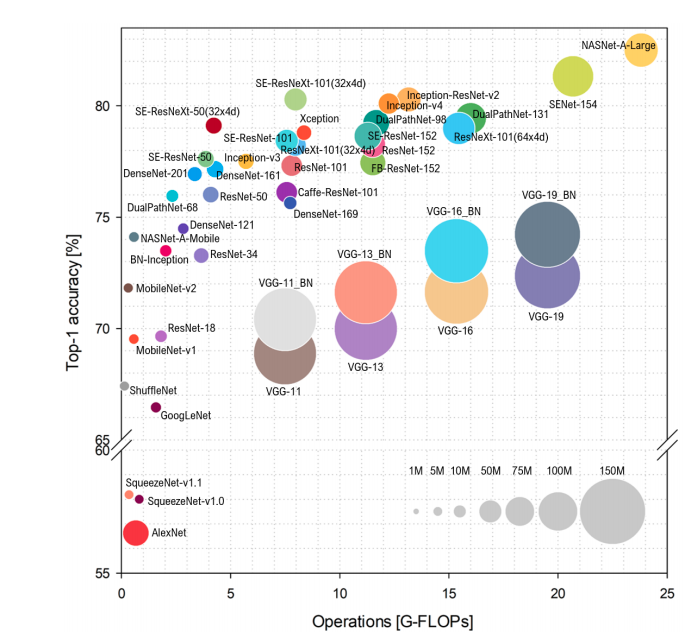

## ResNet vs. ResNeXt

The widget below calculates the number of parameters in a ResNet and ResNeXt.

Note how many parameters the ResNeXt networks take, especially as you increase the number of filters.

In [ ]:
# @title Parameter Calculator

def calculate_parameters(filter_count, path_count):
    # ResNet math: Implement how parameters scale as a function of feature maps and path in ResNet vs ResNeXt

    # fixed # in/out channels 256
    in_channels = out_channels = 256
    # resneXt filter size
    d = filter_count // path_count if path_count>0 else filter_count

    resnet_parameters = in_channels*filter_count + 3*3*filter_count*filter_count + filter_count*out_channels
    resnext_parameters = in_channels*d + 3*3*d*d + d*out_channels

    print('ResNet parameters: {}'.format(resnet_parameters))
    print('ResNeXt parameters: {}'.format(resnext_parameters))

    return None

_ = widgets.interact(calculate_parameters, 
                     filter_count=(16, 1024, 16), 
                     path_count=(0, 64, 4))


## Exercise 5.1

How do parameter savings depend on number of feature maps, 32 vs. 1024?

In [ ]:
parameter_savings_features = '' #@param {type:"string"}

How do parameter savings depend on number of paths, 4 vs. 64?

In [ ]:
parameter_savings_paths = '' #@param {type:"string"}

## Depthwise seperable convolutions

Another way to reduce the computational cost of large models is the use of depthwise seperable convolutions.

The widget below calculates the number of parameters of a regular convolution vs. depthwise seperable convolution.

In [ ]:
# @title Parameter Calculator

def calculate_parameters(in_channels, filter_count, out_channels):
    # Convolution math: Implement how parameters scale as a function of feature maps and path in convolution vs depth-separable convolution

    conv_parameters = in_channels*filter_count*filter_count*out_channels
    dconv_parameters = in_channels*filter_count*filter_count + in_channels*out_channels

    print('Regular convolution parameters: {}'.format(conv_parameters))
    print('Depthwise convolution parameters: {}'.format(dconv_parameters))

    return None

_ = widgets.interact(calculate_parameters, 
                    in_channels=(2, 64, 2),
                     filter_count=(2, 64, 2), 
                     out_channels=(2, 64, 2))


## Exercise 5.2

How do parameter savings depend the on number of feature maps, 4 vs. 64?

In [ ]:
parameter_savings = '' #@param {type:"string"}

---
# Section 6:Transfer Learning




In [ ]:
#@title Video: Domain Adaptation
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="t4ZK2mhfIn8", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

The most common way large image models are trained in practice is via a type of transfer learning called "fine-tuning". Fine-tuning involves a network pretrained on a large dataset like ImageNet, then retraining that network on your task of choice. 

While training a network twice sounds like a strange thing to do, the model ends up training faster on the target domain. There are also other benefits such as [robustness to noise](https://arxiv.org/pdf/1901.09960.pdf) that are the subject of [active research](https://arxiv.org/abs/2008.11687).

In this section we will demonstrate fine-tuning by taking a model trained on ImageNet and teaching it to classify Pokemon.

## Download and prepare the data

In [ ]:
# @title Download Data
!git clone --quiet https://github.com/ben-heil/cis_522_data.git
!tar -xzf cis_522_data/archive.tar.gz
!tar -xzf cis_522_data/faces.tar.gz

In [ ]:
# List the different Pokemon
!ls small_pokemon_dataset/

In [ ]:
# @title Determine number of classes
num_classes = 0
for folders in os.listdir('small_pokemon_dataset/'):
    num_classes += 1
print(num_classes, 'types of Pokemon')

In [ ]:
# @title Display Example Images 
train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                     transforms.ToTensor()))    

pokemon_dataset = ImageFolder('small_pokemon_dataset', transform=train_transform)

image_count = len(pokemon_dataset) 
train_indices = []
test_indices = []
for i in range(image_count):
    # Put ten percent of the images in the test set
    if random.random() < .1:
        test_indices.append(i)
    else:
        train_indices.append(i)

pokemon_test_set = torch.utils.data.Subset(pokemon_dataset, test_indices)  
pokemon_train_set = torch.utils.data.Subset(pokemon_dataset, train_indices)  

pokemon_train_loader = torch.utils.data.DataLoader(pokemon_train_set,
                                                   batch_size=16,
                                                   shuffle=True,)
pokemon_test_loader = torch.utils.data.DataLoader(pokemon_test_set,
                                                  batch_size=16)

dataiter = iter(pokemon_train_loader)
images, labels = dataiter.next()

# show images
plt.imshow(make_grid(images, nrow=4).permute(1,2,0))

In [ ]:
image_count

## Finetuning the Resnet

It is common in computer vision to take a large model trained on a large dataset (often ImageNet) and fine-tune it to perform a different task. In this case we're using a pre-trained ResNet model to classify types of Pokemon.

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
# reset final fully connected layer, number of classes = types of Pokemon = 9
resnet.fc = nn.Linear(num_ftrs, num_classes)
resnet.to(device)
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# @title Finetune ResNet
pretrained_accs = []
for epoch in range(10):
    # Train loop
    for batch in pokemon_train_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = resnet(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

    # Eval loop
    with torch.no_grad():
        loss_sum = 0
        total_correct = 0
        total = len(pokemon_test_set)
        for batch in pokemon_test_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            output = resnet(images)
            loss = loss_fn(output, labels)
            loss_sum += loss.item()

            predictions = torch.argmax(output, dim=1)
            
            num_correct = torch.sum(predictions == labels)
            total_correct += num_correct

        # Plot accuracy
        pretrained_accs.append(total_correct / total)
        plt.plot(pretrained_accs)
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.title('Pokemon prediction accuracy')
        display.clear_output(wait=True)
        display.display(plt.gcf())

## Train only linear readout

Another possible way to make use of transfer learning is to take a pre-trained model and replace the last, linear layer which is also called the readout. Instead of fine-tuning the whole model as before, we train only the readout.

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
num_ftrs = resnet.fc.in_features
# reset final fully connected layer
resnet.fc = nn.Linear(num_ftrs, num_classes)
resnet.to(device)
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# @title Finetune readout of ResNet
linreadout_accs = []
for epoch in range(10):
    # Train loop
    for batch in pokemon_train_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = resnet(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

    # Eval loop
    with torch.no_grad():
        loss_sum = 0
        total_correct = 0
        total = len(pokemon_test_set)
        for batch in pokemon_test_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            output = resnet(images)
            loss = loss_fn(output, labels)
            loss_sum += loss.item()

            predictions = torch.argmax(output, dim=1)
            
            num_correct = torch.sum(predictions == labels)
            total_correct += num_correct

        # Plot accuracy
        linreadout_accs.append(total_correct / total)
        plt.plot(linreadout_accs)
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.title('Pokemon prediction accuracy')
        display.clear_output(wait=True)
        display.display(plt.gcf())

## Training ResNet from scratch

In [ ]:
resnet = torchvision.models.resnet18(pretrained=False)
num_ftrs = resnet.fc.in_features
# reset final fully connected layer
resnet.fc = nn.Linear(num_ftrs, num_classes)
resnet.to(device)
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
# @title Train ResNet from scratch
scratch_accs = []
for epoch in range(10):
    # Train loop
    for batch in pokemon_train_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = resnet(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

    # Eval loop
    with torch.no_grad():
        loss_sum = 0
        total_correct = 0
        total = len(pokemon_test_set)
        for batch in pokemon_test_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            output = resnet(images)
            loss = loss_fn(output, labels)
            loss_sum += loss.item()

            predictions = torch.argmax(output, dim=1)
            
            num_correct = torch.sum(predictions == labels)
            total_correct += num_correct

        scratch_accs.append(total_correct / total)
        plt.plot(scratch_accs)
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.title('Pokemon prediction accuracy')
        
        display.clear_output(wait=True)
        display.display(plt.gcf())

## Head to Head Comparison
Starting from a randomly initialized network works less well, especially in the case of small datsets. Note that the model converges more slowly and less evenly.

In [ ]:
# @title Plot Accuracies
plt.plot(pretrained_accs, label='Pretrained: fine-tuning')
plt.plot(linreadout_accs, label='Pretrained: linear Readout')
plt.plot(scratch_accs, label='Trained from Scratch')
plt.title('Pokemon prediction accuracy')
plt.legend()
plt.show()


## Exercise 6.1

First, we compare the Pretrained ResNet with the ResNet trained from scratch. Why might pretrained models outperform models trained from scratch? In what cases would you expect them to be worse?

In [ ]:
when_pretraining_works = '' #@param {type:"string"}

t5 = time.time()

In [ ]:
# to_remove solution

# 1. The closer your pretraining and target data domains are, the better pretraining will work
# 2. The more pretraining data you have, the better pretraining will work
# 3. The better your model is able to take advantage of your pretraining data (that is to say
#    the larger your model is assuming you have enough data), the better pretraing will work

# Pretraining isn't necessarily always a benefit though. If you source domain is very different from
# the domain you're trying to predict, your models might learn unhelpful features. 
# Additionally, if you have a lot of training data in your target domain, pretraining data might 
# cause your model to converge to a local minimum (this process is referred to as ossification in 
# the Scaling Laws for Transfer paper cited in the Further Reading section)

## Exercise 6.2

Second, take a look at the different transfer learning methods - fine-tuning the whole network and training only the readout. Why might fine-tuning the whole network outperform training only the readout? What are the benefits of training only the readout? In what cases would you expect a similar performance of both methods?

In [ ]:
linear_readout = '' #@param {type:"string"}

In [ ]:
# to_remove solution

# 1. More weights are adjusted to the pretraining domain.
# 2. Since only one layer is trained, the training procedure is faster/less computationally expensive.
# 3. If your pretraining and target data domains are close.

### Further Reading
Supervised pretraining as you've seen here is useful, but there are several other ways of using outside data to improve your models. The ones that are particularly popular right now are [contrastive learning](https://arxiv.org/pdf/2002.05709.pdf) techniques that learn features from unsupervised image data and all sorts of methods of masking input for training [transformer models](https://arxiv.org/pdf/1810.04805.pdf).

There is also a [recent paper](https://arxiv.org/abs/2102.01293) that seeks to quantify the relationship between model size, pretraining dataset size, training dataset size, and performance.

---
# Section 7: Compute-performance tradeoff / Different backbones


In [ ]:
#@title Video: Continual Learning
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="50prJUXLOPw", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

# TODO
- Exercise/code showing performance on transfer task
Widget/plot showing compute/memory requirements
- Is it just a plot or could this be made interactive somehow?

---
# Section 8: Facial Recognition

One application of large CNNs is **facial recognition**. The problem formulation in facial recognition is a little different from the image classification we've seen so far. In facial recognition we don't want to have a fixed number of individuals that the model can learn. If that were the case then to learn a new person it would be necessary to modify the output portion of the architecture and retrain to account for the new person.

Instead, we train a model to learn an **embedding** where images from the same individual are close to each other in a embedded space, and images corresponding to different people are far apart. 

To achieve this, facial recognitions typically use a triplet loss that compares and two images from the same individual (the "anchor" and "positive" images) and a negative image from a different individual (the "negative" image). The loss requires the distance between the anchor and negative points to be greater than a margin $\alpha$ + the distance between the anchor and positive points.

### View and transform the data

A well-trained facial recognition system should be able to map different images of the same individual relatively close together. We will load 15 images of three individuals (maybe you know them - then you can see that your brain is quite well in facial recognition).

After viewing the images, we will transform them: MTCNN detects the face and crops the image around the face. Then we stack all the images together in a tensor.

In [ ]:
# @title Display Images 
# @markdown Here are the source images of Bruce Lee, Neil Patrick Harris, and Pam Grier
train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                     transforms.ToTensor()))    

face_dataset = ImageFolder('faces', transform=train_transform)

image_count = len(face_dataset) 

face_loader = torch.utils.data.DataLoader(face_dataset,
                                          batch_size=45,
                                          shuffle=False)

dataiter = iter(face_loader)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(15,15))
plt.imshow(make_grid(images, nrow=15).permute(1,2,0))

In [ ]:
# @title Image Preprocessing Function
def process_images(image_dir: str, size = 256):
    """
    This function returns two tensors for the given image dir: one usable for inputting into the 
    facenet model, and one that is [0,1] scaled for visualizing

    Parameters:
        image_dir: The glob corresponding to images in a directory

    Returns:
        model_tensor: A image_count x channels x height x width tensor scaled to between -1 and 1,
                      with the faces detected and cropped to the center using mtcnn
        display_tensor: A transformed version of the model tensor scaled to between 0 and 1
    """
    mtcnn = MTCNN(image_size=size, margin=32)
    images = []
    for img_path in glob.glob(image_dir):
        img = Image.open(img_path)
        # Normalize and crop image
        img_cropped = mtcnn(img)
        images.append(img_cropped)

    model_tensor = torch.stack(images)
    display_tensor = model_tensor / (model_tensor.max() * 2)
    display_tensor += .5

    return model_tensor, display_tensor

Now that we have our images loaded, we need to preprocess them. To make the images easier for the network to learn, we crop them to include just faces.

In [ ]:
bruce_tensor, bruce_display = process_images('faces/bruce/*.jpg')
neil_tensor, neil_display = process_images('faces/neil/*.jpg')
pam_tensor, pam_display = process_images('faces/pam/*.jpg')


display_tensor = torch.cat((bruce_display, neil_display, pam_display))

plt.figure(figsize=(15,15))
plt.imshow(make_grid(display_tensor, nrow=15).permute(1, 2,0,))

## Embedding with a pretrained network 

We load a pretrained facial recognition model called [FaceNet](https://github.com/timesler/facenet-pytorch). It was trained on the [VGGFace2](https://github.com/ox-vgg/vgg_face2) dataset which contains 3.31 million images of 9131 individuals.

We use the pretrained model to calculate embeddings for all of our input images.

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [ ]:
# Calculate embedding
resnet.classify = False
bruce_embeddings = resnet(bruce_tensor.to(device))
neil_embeddings = resnet(neil_tensor.to(device))
pam_embeddings = resnet(pam_tensor.to(device))

## Task

- What are the dimensions of one input image?
- What are the dimensions of one stack of images (e.g. bruce_tensor)?
- What are the dimensions of the corresponding embedding (e.g. bruce_embeddings)?
- What would be the dimensions of the embedding of one input image?

In [ ]:
# Your code here:

We cannot show 512-dimensional vectors visually, but using **Principal Component Analysis (PCA)** we can project the 512 dimensions onto a 2-dimensional space while preserving the maximum amount of data variation possible. This is just a visual aid for us to understand the concept. If you would do any caluclation, like distances between two images, this would be done with the whole 512-dimensional embedding vectors.

In [ ]:
embedding_tensor = torch.cat((bruce_embeddings, neil_embeddings, pam_embeddings)).to(device = 'cpu')
pca = sklearn.decomposition.PCA(n_components=2)
pca_tensor = pca.fit_transform(embedding_tensor.detach().numpy())

In [ ]:
colors = ['blue'] * 15 + ['orange'] * 15 + ['magenta'] * 15

plt.scatter(pca_tensor[:,0], pca_tensor[:,1], c=colors, marker = 'x')
green_patch = mpatches.Patch(color='blue', label='Bruce Lee')
orange_patch = mpatches.Patch(color='orange', label='Neil Patrick Harris')
purple_patch = mpatches.Patch(color='magenta', label='Pam Grier')

plt.title('PCA Representation of the Image Embeddings')
plt.legend(handles=[green_patch, orange_patch, purple_patch])

Great! The images corresponding to each individual are separated from each other in the embedding space!

If Neil Patrick Harris wants to unlock his phone with facial recognition, the phone takes the image from the camera, calculates the embedding and checks if it is close to the registered embeddings corresponding to Neil Patrick Harris.

---
# Section 9: Ethics: bias/discrimination due to pre-training datasets
Popular facial recognition datasets like VGGFace2 and CASIA-WebFace consist primarily of caucasian faces. 
As a result, even state of the art facial recognition models [substantially underperform](https://openaccess.thecvf.com/content_ICCV_2019/papers/Wang_Racial_Faces_in_the_Wild_Reducing_Racial_Bias_by_Information_ICCV_2019_paper.pdf) when attempting to recognize faces of other races.

Given the implications that poor model performance can have in fields like security and criminal justice, it's very important to be aware of these limitations if you're going to be building facial recognition systems.

In this example we will work with a small subset from the [UTKFace](https://susanqq.github.io/UTKFace/) dataset with 49 pictures of black women and 49 picture of white men. We will use the same pretrained model as in Section 8, see and discuss the consequences of the model being trained on an imbalanced dataset.

In [ ]:
# @title Download Data
!git clone --quiet https://github.com/richardvogg/face_sample.git
!unzip -q face_sample/face_sample2.zip

### Load, view and transform the data

In [ ]:
black_female_tensor, black_female_display = process_images('face_sample2/??_1_1_*.jpg', size = 200)
white_male_tensor, white_male_display = process_images('face_sample2/??_0_0_*.jpg', size = 200)

We can check the dimensions of these tensors and see that for each group we have images of size 200x200 and three channels (RGB) of 49 individuals.

In [ ]:
print(white_male_tensor.shape)
print(black_female_tensor.shape)

torch.Size([49, 3, 200, 200])
torch.Size([49, 3, 200, 200])


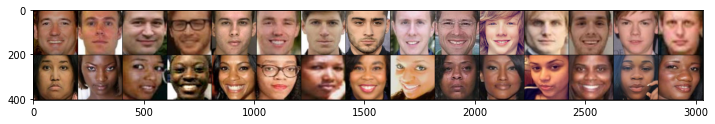

In [ ]:
# @markdown Visualize some example faces
display_tensor = torch.cat((white_male_display[:15], black_female_display[:15]))

plt.figure(figsize=(12,12))
plt.imshow(make_grid(display_tensor, nrow = 15).permute(1, 2,0,))

### Calculate embeddings

We use the same pretrained facial recognition network as in section 8 to calculate embeddings.

In [ ]:
resnet.classify = False
black_female_embeddings = resnet(black_female_tensor.to(device))
white_male_embeddings = resnet(white_male_tensor.to(device))

Calculate the distance between each pair of image embeddings in our tensor and visualize all the distances. Remember that two embeddings are vectors and the distance between two vectors is the Euclidean distance.

In [ ]:
#@markdown Function to calculate pairwise distances
def calculate_pairwise_distances(embedding_tensor: torch.tensor):
    """
    This function calculates the distance between each pair of image embeddings in a tensor

    Parameters:
        embedding_tensor: A num_images x embedding_dimension tensor

    Returns:
        distances: A num_images x num_images tensor containing the pairwise distances between each 
                   image embedding
    """

    distances = torch.cdist(embedding_tensor, embedding_tensor)

    return distances

(-0.5, 97.5, 97.5, -0.5)

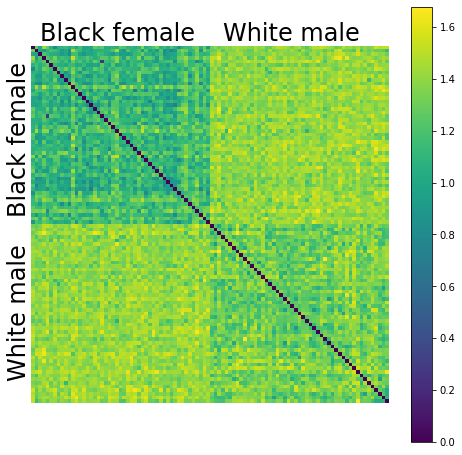

In [ ]:
#@markdown Visualize the distances

embedding_tensor = torch.cat((black_female_embeddings, white_male_embeddings)).to(device = 'cpu')

distances = calculate_pairwise_distances(embedding_tensor)

plt.figure(figsize=(8,8))
plt.imshow(distances.detach().numpy())
plt.annotate('Black female', (2,-0.5), fontsize=24, va='bottom')
plt.annotate('White male', (52,-0.5), fontsize=24, va='bottom')
plt.annotate('Black female', (-0.5, 45), fontsize=24, rotation=90, ha='right')
plt.annotate('White male', (-0.5, 90), fontsize=24, rotation=90, ha='right')
plt.colorbar()
plt.axis('off')

What do you observe? The faces of which group are more similar to each other for the Face Detection algorithm?

Discuss:
- What does it mean in real life applications that the WSS is smaller for the embeddings of one group?
- Can you come up with example situations/applications where this has a negative impact?
- What could you do to avoid these problems?




### Optional: Within Sum of Squares

We can try to put this observation in numbers. For this we work with the embeddings.
We want to calculate the centroid of each group, which is the average of the 49 embeddings of the group. As each embedding vector has a dimension of 512, the centroid will also have this dimension.

Now we can calculate how far away the observations of each group $S_i$ are from the centroid $\mu_i$. This concept is known as Within Sum of Squares (WSS) from cluster analysis.

$ \text{WSS} = \sum_{x\in S_i} ||x - \mu_i||^2$

where ||.|| is the Euclidean norm.

If the WSS is small, all elements of a group are close to each other. If WSS is larger, they are further away from each other.


In [ ]:
def wss(group):
  """
    This function returns the sum of squared distances of the N vectors of a 
    group tensor (N x K) to its centroid (1 x K).

    Parameters:
        group: A image_count x embedding_size tensor

    Returns:
        sum_sq: A 1x1 tensor with the sum of squared distances.

    Hints:
        - to calculate the centroid, torch.mean() will be of use.
        - We need the mean of the N=49 observations. If our input tensor is of size
          N x K, we expect the centroid to be of dimensions 1 x K. 
          Use the axis argument within torch.mean
    """
  centroid = torch.mean(group, axis = 0)
  distance = torch.linalg.norm(group - centroid.view(1,-1), axis = 1)
  sum_sq = torch.sum(distance**2)
  return sum_sq

print("Black female embedding WSS: " + str(round(wss(black_female_embeddings).item(), 2)))
print("White male embedding WSS: " + str(round(wss(white_male_embeddings).item(), 2)))


Black female embedding WSS: 30.97
White male embedding WSS: 41.52
